<a href="https://colab.research.google.com/github/lorenzkuhn/advi/blob/main/GammaPoisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.1 Data download and Initialization**

These first few cells install pyro and download the frey faces Dataset
What we need from here is the ```ff``` numpy array that holds all the frey faces with ```shape``` 1965x28x20.

TODO: actually use test split for verification instead of using everything for training
TODO2: HMC not running properly



In [ ]:
!pip3 install pyro-ppl 

In [ ]:
import torch
import pyro
import pyro.distributions as dist
import torch.distributions.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# get frey faces
# download and visualization snippet copied from https://dohmatob.github.io/research/2016/10/22/VAE.html

import os
from urllib.request import urlopen, URLError, HTTPError
from scipy.io import loadmat


def fetch_file(url):
    """Downloads a file from a URL.
    """
    try:
        f = urlopen(url)
        print("Downloading data file " + url + " ...")

        # Open our local file for writing
        with open(os.path.basename(url), "wb") as local_file:
            local_file.write(f.read())
        print("Done.")

    #handle errors
    except (HTTPError, e):
        print("HTTP Error:", e.code, url)
    except (URLError, e):
        print("URL Error:", e.reason, url)
        
url =  "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat"
data_filename = os.path.basename(url)
if not os.path.exists(data_filename):
    fetch_file(url)
else:
    print("Data file %s exists." % data_filename)
    
# reshape data for later convenience
img_rows, img_cols = 28, 20
ff = loadmat(data_filename, squeeze_me=True, struct_as_record=False)
ff = ff["ff"].T.reshape((-1, img_rows, img_cols))

Data file frey_rawface.mat exists.


**1.2 Helper functions**

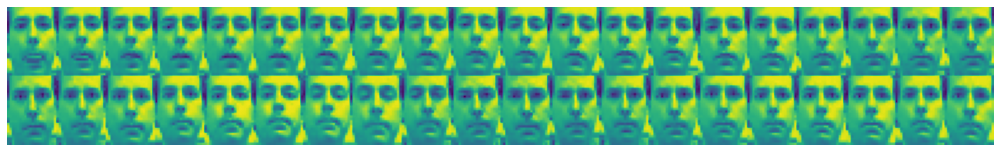

In [ ]:
# Draws the pictures for visual inspection
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(14, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=40)

In [ ]:
# visualize learned factors
def show_factors(learned_beta, learned_theta):
    print(learned_theta.shape)
    print(learned_beta.shape)

    factors = torch.empty(size=(10, 28, 20))
    for i in range(10):
        factors[i,:,:] = dist.Poisson(torch.ger(torch.transpose(learned_theta, 0, 1)[:,i], learned_beta[i,:])).mean

    factors_np = factors.detach().numpy()
    # show_examples(factors_np + ff.mean(axis=0), 10, 5)
    show_examples(factors_np, 10, 5)

In [ ]:
# split data into training and test sets
from torch.utils.data import DataLoader

train_set, test_set = torch.utils.data.random_split(ff, [1572, 393])
train_loader = DataLoader(train_set, batch_size=1572)
test_loader = DataLoader(test_set, batch_size=393)

**2. Model Definition**
The Gamma-Poisson Model is defined here and valid for all approximation/sampling techniques.

In [ ]:
def model(data, U = 28, I = 20, K = 10):
    # Draw parameters
    theta = pyro.sample('theta', dist.Gamma(1., 1.).expand([K, U]).to_event(2))
    beta = pyro.sample('beta', dist.Gamma(1., 1.).expand([K, I]).to_event(2))

    # Generate observations
    with pyro.plate("data", len(data)):
        obs = pyro.sample("obs", dist.Poisson(torch.mm(torch.transpose(theta, 0, 1), beta)).to_event(2), obs = data)

    return obs

**3.1 ADVI**
The ADVI implementation consists of a custom positive-ordered transformation, the custom guide and the actual learning.

In [ ]:
# TRANSFORM
# This is numerically unstable
class ordered_transform_broken(transforms.Transform):
      bijective = True
      domain = dist.constraints.real_vector
      codomain = dist.constraints.real_vector
      sign = +1

      def _call(self, x):
          y = torch.zeros_like(x)
          for i in range(x.size(dim=1)):
              if i == 0:
                  y[:,i] = x[:,i]
              else:
                  y[:,i] = torch.exp(x[:,i]) + x[:,i-1]
          return y

      def _inverse(self, x):
          y = torch.zeros_like(x)
          for i in range(x.size(dim=1)):
              if i == 0:
                  y[:,i] = x[:,i]
              else:
                  y[:,i] = torch.log(x[:,i] - x[:,i-1])
          return y

      def log_abs_det_jacobian(self, x, y):
          z = torch.ones(y.size(dim=0))
          for i in range(y.size(dim=1)):
              if i > 0:
                  z = z * torch.exp(y[:,i])
          return z

# positive_ordered_transform = transforms.ComposeTransform([transforms.ExpTransform(), ordered_transform()])

# This is what I am actually using
class positive_ordered_transform(transforms.Transform):
      bijective = True
      domain = dist.constraints.real_vector
      codomain = dist.constraints.real_vector
      sign = +1

      def _call(self, x):
          y = torch.zeros_like(x)
          for i in range(x.size(dim=0)):
              if i == 0:
                  y[i] = torch.exp(x[i])
              else:
                  y[i] = torch.exp(x[i]) + y[i-1]
          assert(torch.isnan(y).any() == False)
          assert(torch.min(y) >= 0)
          return y

      def _inverse(self, x):
          y = torch.zeros_like(x)
          for i in range(x.size(dim=0)):
              if i == 0:
                  y[i] = torch.log(x[i])
              else:
                  y[i] = torch.log(x[i] - x[i-1])
          assert(torch.isnan(y).any() == False)
          return y

      # TODO: double-check mathematical correctness of this!
      def log_abs_det_jacobian(self, x, y):
          return x.sum(axis=1)

In [ ]:
# GUIDE
def guide(y, U = 28, I = 20, K = 10):
    # theta params
    theta_mu = torch.randn([K,U])
    theta_sigma = torch.randn([K,U])
    theta_mu_param = pyro.param("theta_mu", theta_mu)
    theta_sigma_param = pyro.param("theta_sigma", theta_sigma)
    pyro.sample("theta", dist.TransformedDistribution(dist.Normal(theta_mu_param, torch.abs(theta_sigma_param)), positive_ordered_transform()).to_event(1))

    # beta params
    beta_mu = torch.randn([K,I])
    beta_sigma = torch.randn([K,I])
    beta_mu_param = pyro.param("beta_mu", beta_mu)
    beta_sigma_param = pyro.param("beta_sigma", beta_sigma)
    pyro.sample("beta", dist.TransformedDistribution(dist.Normal(beta_mu_param, torch.abs(beta_sigma_param)), transforms.ExpTransform()).to_event(2))

In [ ]:
# LEARN
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.1})
svi = SVI(model, guide, adam, loss=Trace_ELBO())
pyro.clear_param_store()

step_ids = []
test_log_predictives = []
for j in range(2000):
    loss = svi.step(torch.tensor(ff))
    # loss = 0
    # for data in train_loader:
    #     loss += svi.step(data)

    if j%10 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(test_set)))

    learned_theta_mu = pyro.get_param_store().get_param('theta_mu')
    learned_beta_mu = pyro.get_param_store().get_param('beta_mu')
    poiss_dist = dist.Poisson(torch.mm(torch.transpose(torch.exp(learned_theta_mu), 0, 1), torch.exp(learned_beta_mu)))
    test_log_prob = poiss_dist.log_prob(torch.tensor(ff)).sum()
    # test_log_prob = 0
    # for data in test_loader:
    #   test_log_prob += poiss_dist.log_prob(data).sum()

    step_ids.append(j)
    test_log_predictives.append(test_log_prob.detach() / float(len(ff) * 20 * 28))

[iteration 0001] loss: 529877.4514
[iteration 0011] loss: 884211.5456
[iteration 0021] loss: 120275.5578
[iteration 0031] loss: 156702.2155
[iteration 0041] loss: 151081.3571
[iteration 0051] loss: 206272.8904
[iteration 0061] loss: 180113.3971
[iteration 0071] loss: 157005.4618
[iteration 0081] loss: 160478.9051
[iteration 0091] loss: 65615.5740
[iteration 0101] loss: 71986.3887
[iteration 0111] loss: 187625.2182
[iteration 0121] loss: 567753.9921
[iteration 0131] loss: 58093.1520
[iteration 0141] loss: 66138.2186
[iteration 0151] loss: 165765.3439
[iteration 0161] loss: 213187.3530
[iteration 0171] loss: 53358.4360
[iteration 0181] loss: 69692.8450
[iteration 0191] loss: 39826.7311
[iteration 0201] loss: 32840.3705
[iteration 0211] loss: 262866.4061
[iteration 0221] loss: 38322.3523
[iteration 0231] loss: 75294.1105
[iteration 0241] loss: 33037.2110
[iteration 0251] loss: 41607.2115
[iteration 0261] loss: 183115.9023
[iteration 0271] loss: 35180.0615
[iteration 0281] loss: 40866.6057

Text(0, 0.5, 'Average log predictive')

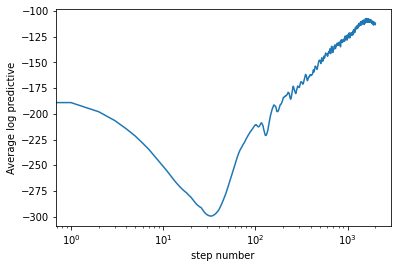

In [ ]:
plt.plot(step_ids, test_log_predictives)
plt.xlabel("step number")
plt.xscale("log")
plt.ylabel("Average log predictive")

theta_mu torch.Size([10, 28])
theta_sigma torch.Size([10, 28])
beta_mu torch.Size([10, 20])
beta_sigma torch.Size([10, 20])
torch.Size([10, 28])
torch.Size([10, 20])


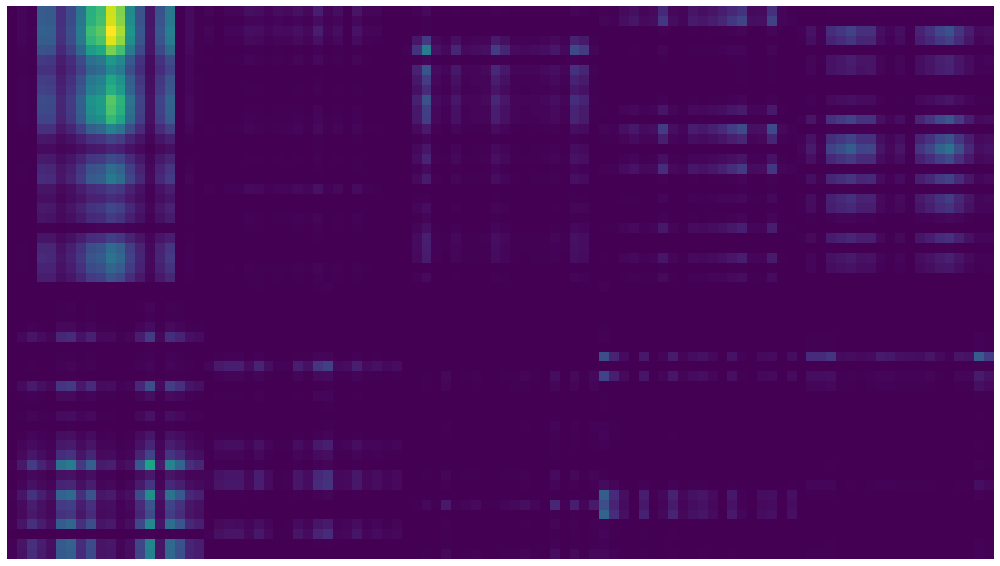

In [ ]:
# reconstruct factor pictures
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

learned_theta_mu = pyro.get_param_store().get_param('theta_mu')
learned_beta_mu = pyro.get_param_store().get_param('beta_mu')

show_factors(torch.exp(learned_beta_mu), torch.exp(learned_theta_mu))

**3.2 NUTS**

Simpler than ADVI, we just use the NUTS sampler and inspect the learned factors.
TODO: log_probs at every step

In [ ]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model, jit_compile=False)
num_samples = 500
mcmc = MCMC(
    nuts_kernel,
    num_samples=num_samples,
    warmup_steps=0,
    num_chains=1,
)

mcmc_step_ids = [0]
mcmc_average_test_log_accuracy = []
mcmc.run(torch.tensor(ff))
# mcmc.summary()

Sample: 100%|██████████| 500/500 [00:29, 16.80it/s, step size=9.77e-04, acc. prob=0.002]


torch.Size([10, 28])
torch.Size([10, 20])


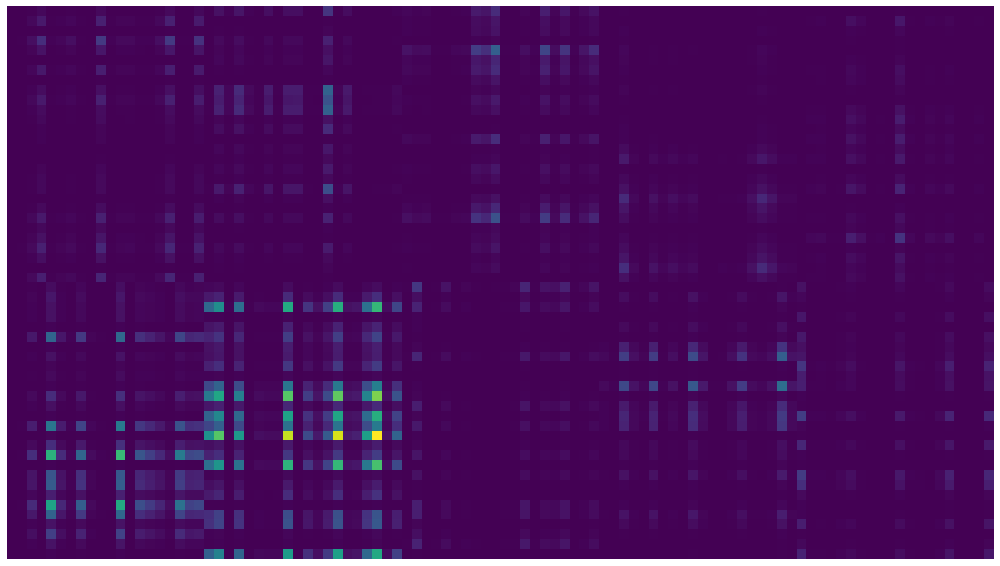

In [ ]:
samples = mcmc.get_samples()
learned_theta = samples['theta'].mean(axis=0)
learned_beta = samples['beta'].mean(axis=0)

show_factors(learned_beta, learned_theta)

**3.3 HMC**

TODO: currently broken :(

In [ ]:
from pyro.infer import HMC
nuts_kernel = HMC(model, step_size=0.9, num_steps=4)
num_samples = 500
mcmc = MCMC(
    nuts_kernel,
    num_samples=num_samples,
    warmup_steps=0,
    num_chains=1,
)

mcmc_step_ids = [0]
mcmc_average_test_log_accuracy = []
mcmc.run(torch.tensor(ff))
mcmc.summary()

Warmup:   0%|          | 0/500 [00:00, ?it/s]

KeyboardInterrupt: ignored